# 07: Final Model Comparison

## Overview

This notebook focuses on evaluating and comparing the performance of several ICU mortality prediction models. It covers the following key areas:

1. **Setup and Data Loading**: Imports necessary libraries, mounts Google Drive to access data and saved evaluation plots.
2. **Model Evaluation Plot Loading**: Loads pre-generated evaluation plots (confusion matrices, ROC curves, PR curves, SHAP plots) for different models.
3. **Data Preparation and Modeling Comparison**: Provides a detailed comparison of the data preparation techniques used for each model and summarizes their architecture and modeling strategies.
4. **Model Evaluation Metrics Comparison**: Presents a table and a bar chart comparing key performance metrics (Accuracy, AUROC, AUPRC, Precision, Recall, F1 Score) across the models.
5. **Visual Comparison of Evaluation Plots**: Displays and interprets the confusion matrices, ROC curves, Precision-Recall curves, and SHAP summary plots for each model to provide a visual comparison of their performance and feature importance.

The notebook concludes with interpretations of the results from the evaluation metrics and plots, discussing the strengths and weaknesses of each model in predicting ICU mortality.

## 1. Import Necessary Libraries

This section imports the necessary Python libraries required for data loading, manipulation and visualization. Key libraries include `os` and `glob` for file system operations, `PIL` for image handling, `pandas` for data structures and analysis, `matplotlib.pyplot` and `seaborn` for plotting, and `warnings` to manage potential warnings during execution.

In [ ]:
import os
import glob
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supress warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Mount Google Drive

This section mounts the Google Drive to access files directly within the Colab environment.

In [ ]:
from google.colab import drive

# Mount Google drive
drive.mount('/content/drive')

# Base file path
basePath = 'drive/MyDrive/Colab Notebooks/AAI-590-01_02/AAI590_CapstoneProject'

Mounted at /content/drive


## 3. Load Model Evaluation Plots

This section defines a function to load model evaluation plots from a specified directory. It uses the `glob` and `os` libraries to find all PNG image files in the given path and the `PIL` library to open and store them in a dictionary, mapping the image filenames to their corresponding image objects. The code then specifies the directory where the evaluation plots are saved and calls the function to load the images, printing the number of loaded images and their names.

In [ ]:
# Function to load images from the specified path
def load_evaluation_plots_from_path(image_path):
    image_files = glob.glob(os.path.join(image_path, '*.png'))
    images = [Image.open(img_file) for img_file in image_files]
    images_mapping = dict(zip([os.path.basename(name) for name in image_files], images))
    return images_mapping

# Note: use below code if running in the local machine
# figures_dir = r'../reports/figures'

# Define the directory where evalution plots are saved
figures_dir = os.path.join(basePath, 'reports', 'figures')

# Load image name and image mapping dictionary
images_mapping = load_evaluation_plots_from_path(figures_dir)

print(f'Number of loaded images: {len(images_mapping)}')

print('\nLoaded image names:')
for image_name, _ in images_mapping.items():
    print(image_name)

Number of loaded images: 16

Loaded image names:
CNN-LSTM_confusion_matrix.png
CNN-LSTM_pr_curve.png
CNN-LSTM_roc_curve.png
CNN-LSTM_shap_summary.png
XGBoost_Optimized_confusion_matrix.png
XGBoost_Optimized_pr_curve.png
XGBoost_Optimized_roc_curve.png
XGBoost_Optimized_shap_summary.png
patchtst_v2_bm_ROC_curve.png
patchtst_v2_bm_confusion_matrix.png
patchtst_v2_bm_precision_recall_curve.png
patchtst_v2_bm_shap_summary_plot.png
timesfm_bm_ROC_curve.png
timesfm_bm_confusion_matrix.png
timesfm_bm_precision_recall_curve.png
timesfm_bm_shap_summary_plot.png


## 4. Compare Data Preparation and Modelling

This section provides a summary of the data preparation steps taken for each model and a comparison of the ICU mortality prediction models. The "Data Preparation Summary by Model" table details the specific data handling techniques applied to each model, highlighting variations in approaches for tasks such as handling missing values, feature selection, time windowing, and class imbalance. The "ICU Mortality Prediction Model Comparison" table provides an overview of each model's architecture, the modeling strategy employed during development and tuning, and the final evaluation approach.

## Data Preparation Summary by Model

| **Action** | **CNN-LSTM** | **XGBoost** | **Transformer** | **Reason** |
|------------|--------------|-------------|------------------|---------------------------|
| Remove empty patients | Yes | Yes | Yes | Ensures valid data for modeling |
| Handle -1 missing sentinel value | Yes (Replace with 0) | Yes (via aggregation or replace with 0) | Yes (via bidirectional fill and hybrid imputation) | Standardizes missing value handling |
| Feature selection| Yes (via EDA + clinical relevance) | Yes (via drop columns with 80% missingness) | Yes (via drop columns with 95% missingness) | Improves model interpretability and performance |
| Exclude outcome features (e.g., SAPS-I, SOFA) | No | No | **Yes** | Avoid **data leakage** |
| Add derived features (e.g., Shock Index) | Yes | Yes | Yes | Enhances physiological signal representation |
| Time windowing | Yes (hourly: [6–48h]) | No | Yes (60-min bins) | Captures temporal dynamics |
| Bidirectional fill | No (Takes first row value) | NA | Yes | Preserve temporal continuity |
| Pad sequences, fill NaNs with 0 | Yes | NA | NA | Ensures uniform input shape for CNN-LSTM |
| Train/Val/Test split | 64:16:20 | 80:20 | 60:20:20 | Enables fair evaluation and tuning |
| StandardScaler | Yes | NA | Yes | Normalizes feature scales for neural models |
| Log-transform skewed static features | Yes | No | NA (Applied Binning) | Reduces skewness and improves generalization |
| Bin and encode | No | No | Yes (for Age, BMI, HR, MAP, GCS) | Simplify signals into interpretable categories and make them model-ready |
| Impute dynamic features | Yes (SimpleImputer) | Yes (KNNImputer) | Yes (Hybrid: patient mean → population median) | Handles missing values for robust training |
| Handle class imbalance | Yes (SMOTE) | Yes (SMOTE) | Yes (RandomWeightedSampler at modelling level) | Balances minority class to improve recall |
| Synthetic static feature alignment | Yes | NA | NA | Ensures modality consistency in CNN-LSTM |
| Encode categorical features | NA | Yes (one-hot encode) | Yes (ordinal-encoder for binned categories) | Converts categorical data for model compatibility |
| Aggregate dynamic data | No | Yes (mean, std, min, max, count) | Yes (mean, sum, last, min for windowing) | Simplifies temporal data |
| Create polynomial features | No | Yes | No | Boosts feature richness for XGBoost |
| Drop superseded features | No | No | Yes | Removes redundancy and improves clarity |


## ICU Mortality Prediction Model Comparison

| Model                     | Architecture                                                                 | Modeling Strategy                                                                                                          | Final Evaluation                          |
|--------------------------|------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------|-------------------------------------------|
| **CNN_LSTM**             | Hybrid CNN + LSTM extracts short- and long-term patterns; late fusion with static features; dense layers with dropout & L2 regularization; sigmoid output <br> Input - dynamic features dataset and stati features dataset| - Experiments on [6, 12, 36, 48] hour windows (50 epochs, batch size 32)  <br> - 5-fold CV on 36 hour window data (25 epochs) <br> - KerasTuner Hyperband for recall optimization on 36 hour window data (17 epochs) | Tuner best model                          |
| **XGBoost**              | Gradient-boosted decision tree ensemble (XGBoost) <br> Input - Aggregated data                                                                 | - Baseline 1: scale_pos_weight on original data <br> - Baseline 2: SMOTE-resampled data (selected for recall) <br> - GridSearchCV on SMOTE-resampled data <br> - Cross validation on multiple feature sets (5-fold CV) <br> - Hyperparameter tuning on data with polynomial + derived features<br> - Threshold tuning for recall | Hyperparameter-tuned best model on data with polynomial + derived features |
| **PatchTSTForClassification** | Transformer with independent channel encoding; instance normalization; patch segmentation; positional-encoding; masked self-supervised learning; classification head <br> Input - combined dynamic and static features dataset| - RandomWeightSampler <br> - Baseline: simple config (50 epochs) <br> - Custom-Cofig: deeper model (50 epochs) <br> - Optuna-tuned: best config (143 epochs) | Optuna-tuned best model                   |
| **TimesFMForPrediction**              | Transformer with residual blocks per patch; multi-head causal attention; FFN layers; static projection; classification head <br> Input - dynamic features dataset and stati features dataset| - RandomWeightSampler <br> - Baseline: pretrained backbone (no training) <br> - Trained: fine-tuned on ICU data (10 epochs) <br> - Optuna-tuned: optimized for AUROC & recall (10 epochs) | Optuna-tuned best model                   |



## 5. Compare Model Evaluation Metrics

This section compares the performance of the different models based on various evaluation metrics. The table displays key metrics such as Accuracy, AUROC, AUPRC, Precision (Died), Recall (Died), and F1 Score (Died) for each optimized model. A bar chart is generated to visually compare these metrics across models, providing a clear overview of their strengths and weaknesses in predicting ICU mortality.

**Interpretations:**

The **XGBoost_Optimized** model demonstrates the highest Accuracy, AUROC, and AUPRC, indicating a strong overall performance and good ability to discriminate between the classes. However, it has the lowest Recall (Died), meaning it identifies fewer true positive cases (patients who died) compared to the other models.

The **CNN_LSTM_Optimized** model has the highest Recall (Died) and a competitive AUROC and AUPRC, suggesting it is better at identifying positive cases, which is often crucial in medical predictions. Its Accuracy is lower than XGBoost, but its F1 Score is the highest, indicating a good balance between precision and recall for the positive class.

The **PatchTSTForClassification_Optimized** and **ICUStaticFusionTimesFM_Optimized** models show similar performance across most metrics, with PatchTST having a slightly higher AUROC and AUPRC, and ICUStaticFusionTimesFM having slightly higher Accuracy. Both have relatively high Recall (Died) but lower Precision (Died) compared to XGBoost, indicating they identify more true positives but also have more false positives.

In summary, while XGBoost has the best overall discrimination and accuracy, the CNN-LSTM model is better at identifying positive cases, which might be preferred depending on the cost of false negatives in the context of ICU mortality prediction. The Transformer models (PatchTST and TimesFM) offer a balance, with decent recall but lower precision than XGBoost. The choice of the best model would depend on the specific priorities and trade-offs between different evaluation metrics for the application.

In [ ]:
compare_model_evaluation_metrics = {
    'Model Name': ['CNN_LSTM_Optimized', 'XGBoost_Optimized', 'PatchTSTForClassification_Optimized', 'ICUStaticFusionTimesFM_Optimized'],
    'Accuracy': [0.6025, 0.86, 0.6103, 0.6366],
    'AUROC': [0.772650, 0.8240, 0.7059, 0.6705],
    'AUPRC': [0.36, 0.4065, 0.2480, 0.2589],
    'Precision (Died)': [0.235294, 0.51, 0.2247, 0.2256],
    'Recall (Died)': [0.828829, 0.23, 0.7455, 0.6727],
    'F1 Score (Died)': [0.364, 0.32, 0.3453, 0.3379],
}

df_metrics = pd.DataFrame(compare_model_evaluation_metrics)

df_metrics

,Model Name,Accuracy,AUROC,AUPRC,Precision (Died),Recall (Died),F1 Score (Died)
0,CNN_LSTM_Optimized,0.6025,0.77265,0.3600,0.235294,0.828829,0.3640
1,XGBoost_Optimized,0.8600,0.82400,0.4065,0.510000,0.230000,0.3200
2,PatchTSTForClassification_Optimized,0.6103,0.70590,0.2480,0.224700,0.745500,0.3453
3,ICUStaticFusionTimesFM_Optimized,0.6366,0.67050,0.2589,0.225600,0.672700,0.3379


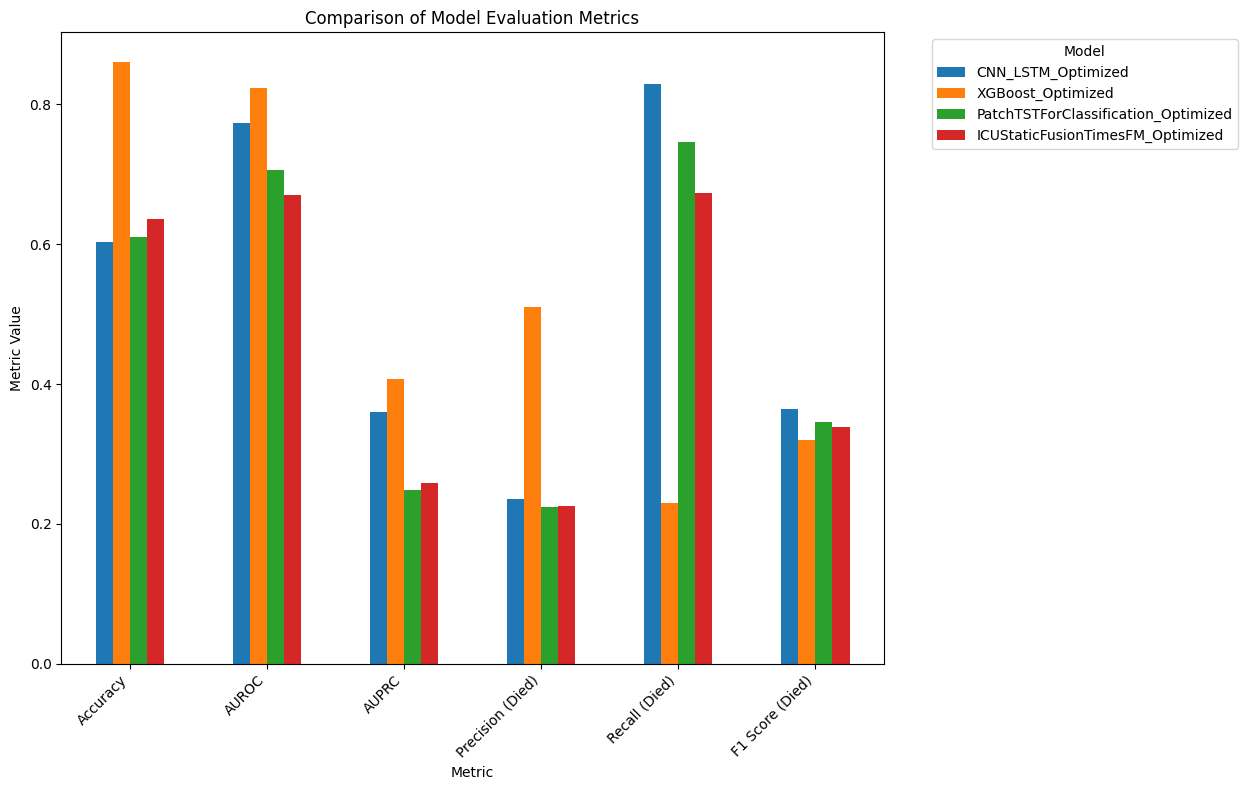

In [ ]:
# Set 'Model Name' as the index for easier plotting
df_metrics = df_metrics.set_index('Model Name')

# Transpose the DataFrame so metrics become columns and models become rows
df_metrics_transposed = df_metrics.transpose()

# Plotting the bar chart
ax = df_metrics_transposed.plot(kind='bar', figsize=(15, 8))

# Place the legend outside the plot to the right
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Comparison of Model Evaluation Metrics')
plt.ylabel('Metric Value')
plt.xlabel('Metric')
plt.xticks(rotation=45, ha='right')
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for the legend

plt.show()

## 6. Compare Model Confusion Matrices

This section visually compares the confusion matrices for each of the optimized models. Confusion matrices provide a detailed breakdown of the model's performance, showing the counts of true positives, true negatives, false positives, and false negatives. By examining these matrices, we can understand how well each model distinguishes between the 'Survived' and 'Died' classes and identify where they make errors.

**Interpretations:**

* **CNN-LSTM Confusion Matrix:** This matrix shows that the CNN-LSTM model has a relatively high number of True Positives (correctly predicted 'Died') and a lower number of False Negatives (incorrectly predicted 'Survived' when the actual was 'Died'). This aligns with its high Recall (Died) score. It also has a significant number of False Positives (incorrectly predicted 'Died' when the actual was 'Survived'), contributing to its lower Precision (Died).
* **XGBoost Optimized Confusion Matrix**: The XGBoost model shows a high number of True Negatives (correctly predicted 'Survived') and a lower number of False Positives. This is consistent with its high Accuracy and Precision (Died). However, it has a higher number of False Negatives compared to the CNN-LSTM model, reflecting its lower Recall (Died).
* **PatchTSTForClassification Confusion Matrix:** This matrix indicates that the PatchTST model has a good number of True Positives, contributing to its relatively high Recall (Died). Similar to the CNN-LSTM, it also has a notable number of False Positives, impacting its Precision (Died).
* **ICUStaticFusionTimesFM Confusion Matrix:** The ICUStaticFusionTimesFM model's confusion matrix shows a similar pattern to the PatchTST model, with a decent number of True Positives and a considerable number of False Positives. Its performance metrics like Recall and Precision for the 'Died' class are also comparable to PatchTST.

In summary, the confusion matrices visually reinforce the findings from the evaluation metrics. The CNN-LSTM and Transformer models prioritize identifying positive cases (higher True Positives and lower False Negatives), while the XGBoost model prioritizes correctly identifying negative cases and minimizing false alarms (higher True Negatives and lower False Positives).

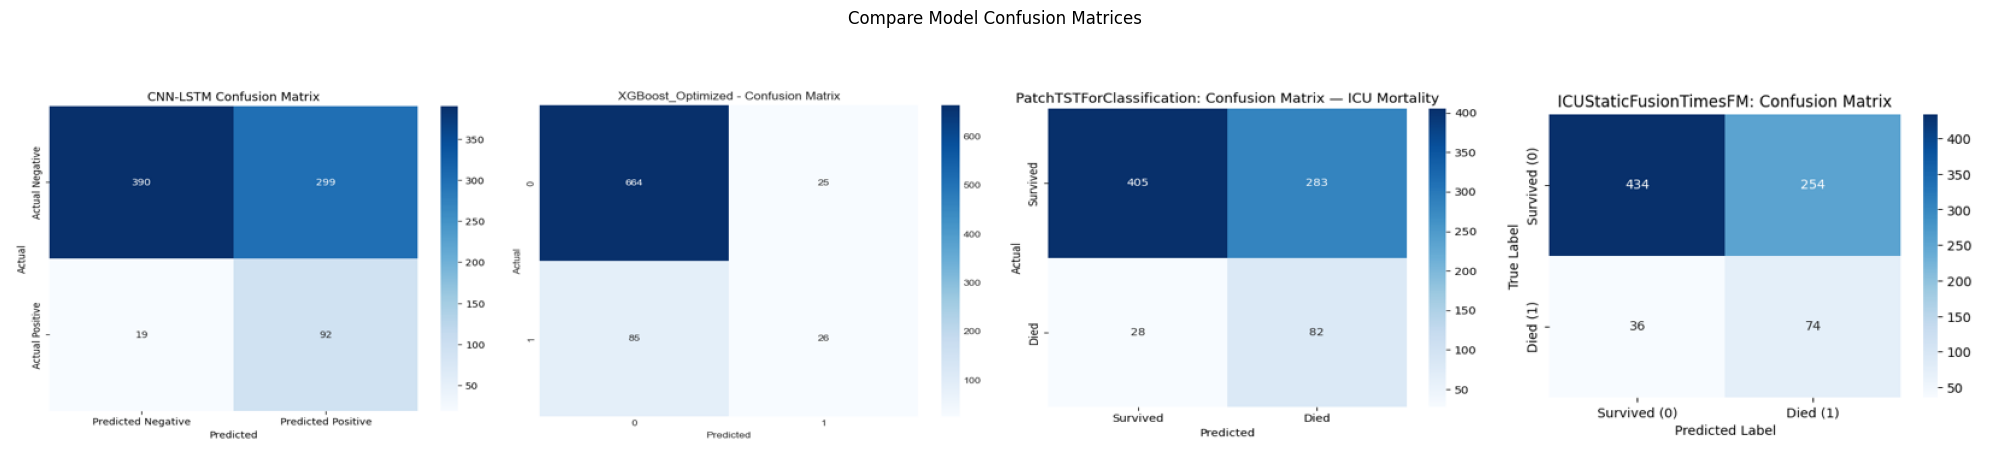

In [ ]:
def display_images(images, title, set_subplot_title=False, common_size=(400, 300), figsize=(20, 5)):
    cols = len(images)
    rows = 1

    # Resize images
    resized_images = {}
    for name, image in images.items():
        resized_image = image.resize(common_size)
        resized_images[name] = resized_image

    # Create a figure and a set of subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    # Iterate through the resized images and display them in subplots
    for i, (name, image) in enumerate(resized_images.items()):
        axes[i].imshow(image)
        if set_subplot_title:
            axes[i].set_title(name.replace('.png', ''))
        axes[i].axis('off')

    plt.suptitle(f"Compare Model {title}")
    plt.tight_layout()
    plt.show()

confusion_matrix_images = {name: image for name, image in images_mapping.items() if 'confusion_matrix' in name}
display_images(confusion_matrix_images, 'Confusion Matrices')

## 7. Compare Model ROC Curves

This section presents the Receiver Operating Characteristic (ROC) curves for each optimized model. ROC curves illustrate the trade-off between the true positive rate and the false positive rate at various threshold settings. The Area Under the ROC Curve (AUROC) is a key metric derived from these curves, representing the model's overall ability to discriminate between the positive and negative classes. A higher AUROC indicates better discrimination.

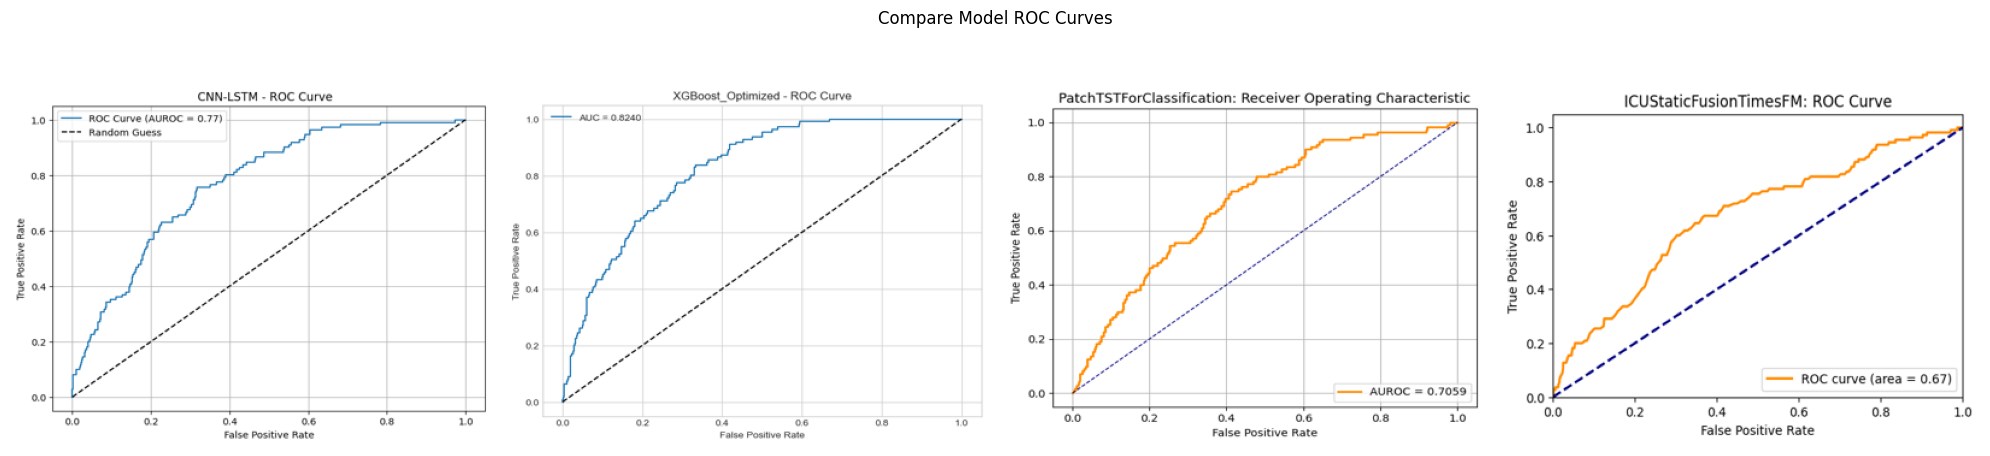

In [ ]:
roc_matrix_images = {name: image for name, image in images_mapping.items() if 'roc_curve' in name.lower()}
display_images(roc_matrix_images, 'ROC Curves')

## 8. Compare Model Precision-Recall Curves

This section displays the Precision-Recall curves for each optimized model. Precision-Recall curves are particularly useful when dealing with imbalanced datasets, as they illustrate the trade-off between precision (the ability to avoid false positives) and recall (the ability to find all positive cases) at various threshold settings. The Area Under the Precision-Recall Curve (AUPRC) provides a single value summarizing the model's performance across all thresholds, with a higher AUPRC indicating better performance, especially for the positive class.

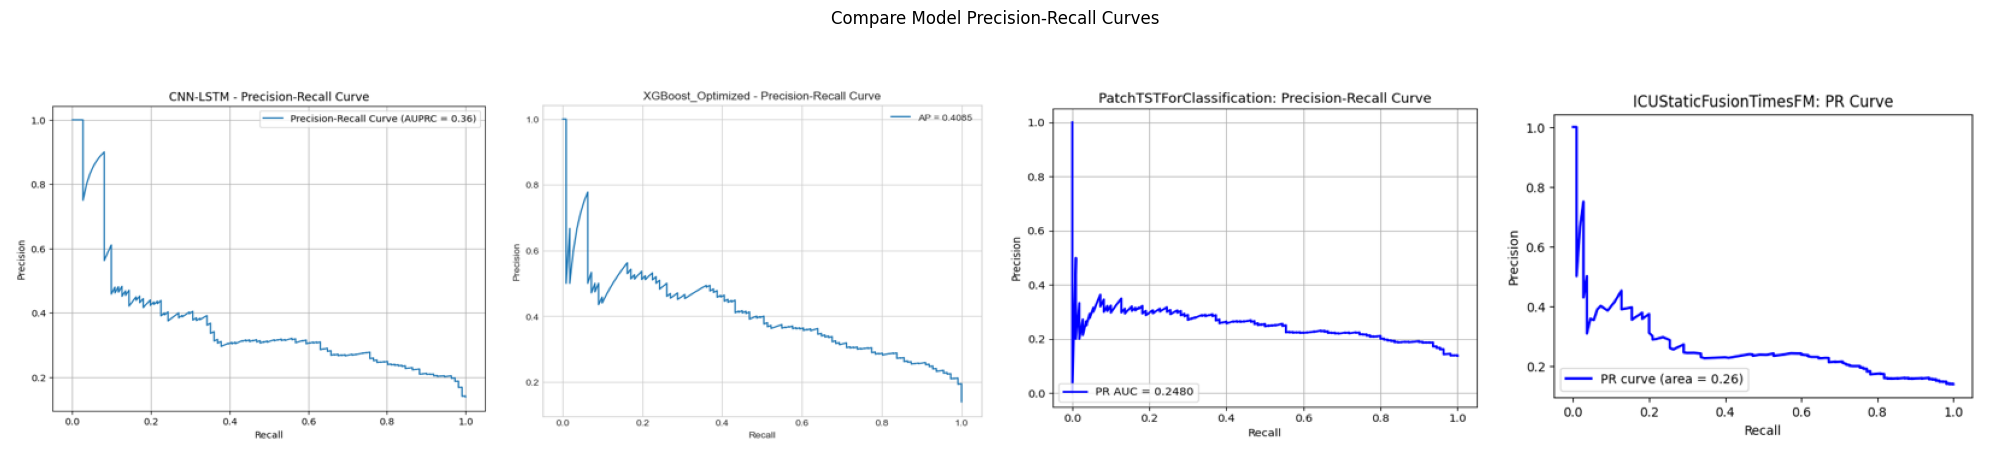

In [ ]:
precision_recall_images = {name: image for name, image in images_mapping.items() if 'precision_recall_curve' in name or 'pr_curve' in name}
display_images(precision_recall_images, 'Precision-Recall Curves')

## 9. Compare SHAP Summary Plots

This section displays SHAP (SHapley Additive exPlanations) summary plots for each optimized model. SHAP values indicate the magnitude and direction of a feature's impact on the model's output. These plots help to understand which features are most important for each model's predictions and how they influence the outcome (e.g., predicting 'Died' or 'Survived'). The plots summarize the SHAP values for each feature across all samples, providing insights into the global feature importance and their distribution of impacts.

**Interpretations:**

* **CNN-LSTM SHAP summary:** This plot shows the feature importance for the CNN-LSTM model. Features like K, HR, GCS, BUN, MechVent, SAPS-I, and Lactate appear to be the most influential features in this model's predictions, with their SHAP values indicating the direction and magnitude of their impact on the output.
* **XGBoost Optimized SHAP summary:** The XGBoost model's SHAP summary plot highlights the most important features for its predictions. Features such as GCS_max, Gender_1, Gender_0, Age, FiO2_count, and ICUtype_2.0 are among the top features influencing the model's output. The color of the dots indicates whether the feature value is high (red) or low (blue), and the position on the x-axis shows the impact on the model output.
* **PatchTSTForClassification SHAP summary plot:** This plot shows the feature importance for the PatchTST model. Features like RespRate, GCS_bin_enc, HR_bin_enc, NIDiasABP, PaO2_FiO2, and NIDSysABP are among the most important features for this model.
* **ICUStaticFusionTimesFM SHAP summary plot:** The TimesFM model's SHAP summary plot indicates the features that are most important for its predictions. Features like AgeBMI_token_encoded, ICUtype, GCS_bin_enc, NIDiasABP, NISysABP and HCT are among the top influential features in this model.

In summary, the SHAP summary plots provide valuable insights into which features are driving each model's predictions and how those features influence the outcome. While some features appear important across multiple models (like GCS, Age, and vital signs), each model also utilizes a unique set of features or different representations of those features based on its architecture and data preparation. This highlights the different approaches each model takes in utilizing the available information for prediction.

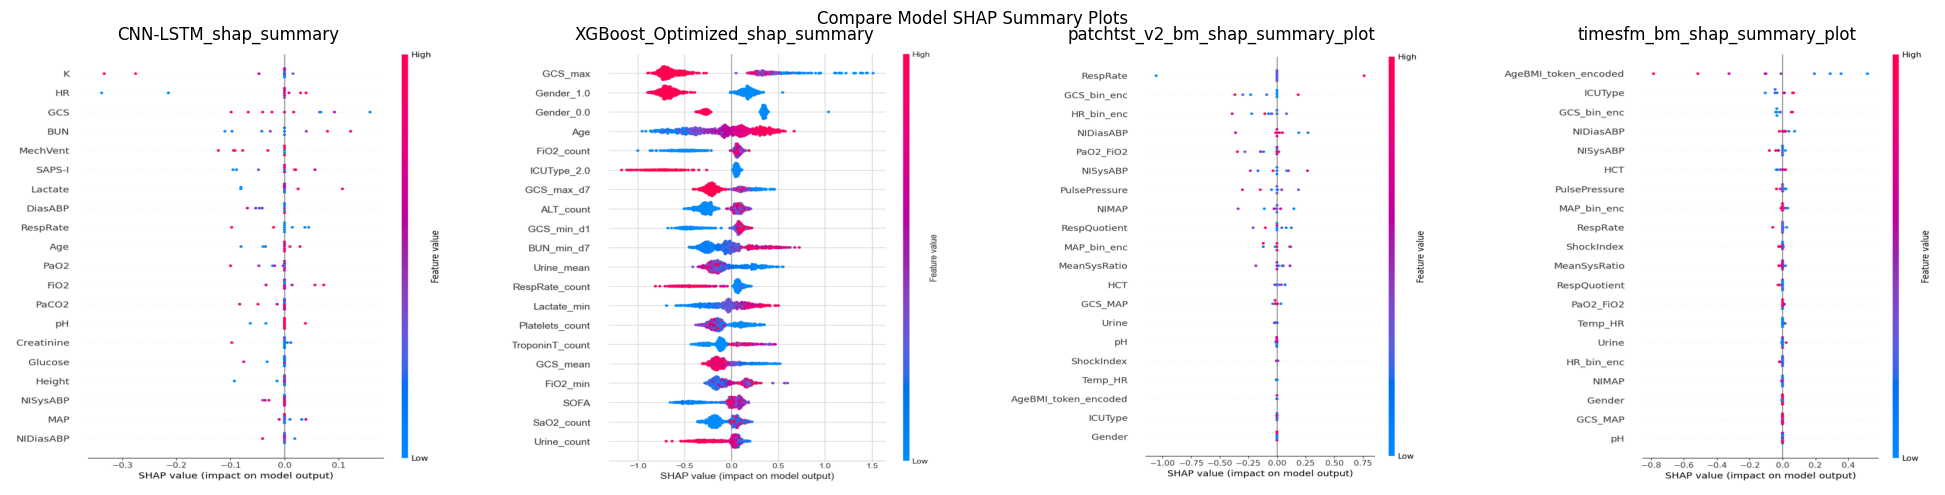

In [ ]:
SHAP_summary_images = {name: image for name, image in images_mapping.items() if 'shap_summary' in name}
display_images(SHAP_summary_images, 'SHAP Summary Plots', set_subplot_title=True, common_size=(800, 800), figsize=(20, 5))